In [1]:
# Importing some shizzle.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import time
import requests
import datetime
import sys
import os
import pathlib
import seaborn as sns
from sklearn.metrics import roc_auc_score
from utilities import calc_z_scores, perform_stats

location = 'rjsietsma'

read_loc = '/home/'+location+'/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/'

imsave_loc = '/home/'+location+'/PycharmProjects/dsls_master_thesis/side_scripts/output_img/'

In [2]:
# Make sure you run the venv before you start up jupyter

from bs4 import BeautifulSoup

In [4]:
# Prepare output directory

if not os.path.exists('./output_img/'):
    os.makedirs('./output_img')

In [5]:
# Loading in the detailed dataset

dataset = pd.read_csv(read_loc+"test_results_genes_auc_exonic.csv", header=0, index_col=0)
dataset['label'].replace({"LB/B":0, "LP/P":1}, inplace=True)
dataset

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic
0,21,33974174,C,G,0.000058,STOP_LOST,0,NaN,NaN,NaN,NaN,15.050,NaN,0.003275,NaN,C21orf59,NaN,1
1,21,33974278,C,CA,0.000045,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,35.000,NaN,0.304741,NaN,C21orf59,NaN,1
2,X,99661625,G,C,0.000037,SYNONYMOUS,0,NaN,NaN,0.00,-0.00,0.806,NaN,0.000075,NaN,PCDH19,0.906593,1
3,X,99663098,G,GT,0.000013,STOP_GAINED,0,NaN,NaN,NaN,NaN,35.000,NaN,0.998694,NaN,PCDH19,0.906593,1
4,X,99662275,C,G,0.000212,NON_SYNONYMOUS,0,0.527,NaN,0.95,2.51,27.000,NaN,0.863940,0.436,PCDH19,0.906593,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10540,22,36662041,AATAATT,A,0.141400,INFRAME,1,NaN,NaN,NaN,8.98,7.508,NaN,0.004829,NaN,APOL1,NaN,1
10541,2,31754497,T,C,0.000033,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,19.790,0.951270,0.918898,NaN,SRD5A2,0.921053,0
10542,2,31754393,C,T,0.000000,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,21.700,NaN,0.985064,NaN,SRD5A2,0.921053,0
10543,2,31758741,T,C,0.000200,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,20.800,0.912937,0.474717,NaN,SRD5A2,0.921053,0


In [6]:
# Loading in the original test_results to see if SNV's are missing

original_dataset = pd.read_csv(read_loc+"test_results.txt", sep='\t', header=0)
original_dataset['label'].replace({"LB/B":0, "LP/P":1}, inplace=True)
original_dataset

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2
0,21,33974174,C,G,0.000058,STOP_LOST,0,NaN,NaN,NaN,NaN,15.050,NaN,0.003275,NaN
1,X,99661625,G,C,0.000037,SYNONYMOUS,0,NaN,NaN,0.000,-0.0,0.806,NaN,0.000075,NaN
2,17,29509638,C,T,0.000000,SYNONYMOUS,0,NaN,NaN,0.647,-0.0,10.760,NaN,0.001511,NaN
3,21,35742999,C,T,0.000133,SYNONYMOUS,0,NaN,NaN,0.000,-0.0,18.640,NaN,0.000621,NaN
4,1,2160973,G,A,0.000000,SYNONYMOUS,0,NaN,NaN,0.000,-0.0,16.340,0.008252,0.000012,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10837,17,29556342,G,A,0.000000,SYNONYMOUS,1,NaN,NaN,0.000,-0.0,11.450,NaN,0.000139,NaN
10838,11,5248177,A,T,0.000344,SYNONYMOUS,1,NaN,NaN,0.000,-0.0,17.970,NaN,0.069934,NaN
10839,15,48787324,T,C,0.000000,SYNONYMOUS,1,NaN,NaN,0.664,-0.0,12.170,0.019530,0.909190,NaN
10840,19,17947957,G,A,0.000015,SYNONYMOUS,1,NaN,NaN,0.000,-0.0,10.990,NaN,0.001238,NaN


In [7]:
# Merging 
missing_o_c = pd.merge(dataset, original_dataset, how='outer', indicator=True)
print(f"Missing number of samples: {missing_o_c[missing_o_c['_merge'] == 'right_only'].shape[0]}")
print(f"Genes that are present in original, but not in processed: {missing_o_c[missing_o_c['_merge'] == 'right_only']['gene'].unique()}")

Missing number of samples: 1935
Genes that are present in original, but not in processed: [nan]


In [8]:
# Deleting the variables
del(missing_o_c, original_dataset)

In [9]:
# Preparing the list of HAIDM

list_of_hereditary_auto_inflammatory_disorder_mutations = []

In [10]:
# Scraping

page_request = requests.get("https://infevers.umai-montpellier.fr/web/index.php")
page_request.close()

In [11]:
# Souping

soup = BeautifulSoup(page_request.content, 'html.parser')

In [12]:
# Genes are in navbar

navbar = soup.find(id='myNavbar')

In [13]:
# Getting the genes.

for link in navbar.find_all('a'):
    get_text = link.get_text().strip()
    if len(get_text) > 0:
        list_of_hereditary_auto_inflammatory_disorder_mutations.append(get_text)

In [14]:
# Loading in the omim gene list and cleaning it.

test_omim = pd.read_csv(read_loc+"genemap2.txt", header=0, sep='\t', skiprows=3)
test_omim = test_omim[test_omim['Genomic Position Start'].notnull()]
test_omim['# Chromosome'] = test_omim['# Chromosome'].apply(lambda x: x.split("chr")[1])
test_omim = test_omim[['# Chromosome', 'Genomic Position Start', 'Genomic Position End', 'Gene Symbols']]
test_omim.columns = ['chr','start','end','gene']
initial_omim_list = list(test_omim['gene'].unique())
actual_omim_list = []
reset_timer = time.time()
done = 0
total = len(initial_omim_list)
for gene in initial_omim_list:
    time_fls = time.time()
    if time_fls - reset_timer > 10:
        print(f"Still processing, done: {round(done/total*100, ndigits=2)}%")
        reset_timer = time.time()
    gene_split = gene.split(", ")
    if len(gene_split) > 1:
        for g in gene_split:
            if g not in actual_omim_list:
                actual_omim_list.append(g)
    else:
        actual_omim_list += gene_split
    done += 1


In [15]:
# Comparing it to the gene list that I currently have.

dataset['in_omim'] = 0

current_gene_list = list(dataset['gene'].unique())
reset_timer = time.time()
done = 0
total = len(actual_omim_list)
in_list = 0
actually_in_dataset = []
for gene in actual_omim_list:
    time_fls = time.time()
    if time_fls - reset_timer > 10:
        print(f"Still processing, done: {round(done/total*100, ndigits=2)}%")
        reset_timer = time.time()
    if gene in current_gene_list:
        actually_in_dataset.append(gene)
        dataset.loc[dataset[dataset['gene'] == gene].index, 'in_omim'] = 1
        in_list += 1
    done += 1
print(f"Total percentage of OMIM loci in dataset: {round(in_list/total*100, ndigits=2)}%")
dataset

Total percentage of OMIM loci in dataset: 4.67%


,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic,in_omim
0,21,33974174,C,G,0.000058,STOP_LOST,0,NaN,NaN,NaN,NaN,15.050,NaN,0.003275,NaN,C21orf59,NaN,1,1
1,21,33974278,C,CA,0.000045,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,35.000,NaN,0.304741,NaN,C21orf59,NaN,1,1
2,X,99661625,G,C,0.000037,SYNONYMOUS,0,NaN,NaN,0.00,-0.00,0.806,NaN,0.000075,NaN,PCDH19,0.906593,1,1
3,X,99663098,G,GT,0.000013,STOP_GAINED,0,NaN,NaN,NaN,NaN,35.000,NaN,0.998694,NaN,PCDH19,0.906593,1,1
4,X,99662275,C,G,0.000212,NON_SYNONYMOUS,0,0.527,NaN,0.95,2.51,27.000,NaN,0.863940,0.436,PCDH19,0.906593,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10540,22,36662041,AATAATT,A,0.141400,INFRAME,1,NaN,NaN,NaN,8.98,7.508,NaN,0.004829,NaN,APOL1,NaN,1,1
10541,2,31754497,T,C,0.000033,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,19.790,0.951270,0.918898,NaN,SRD5A2,0.921053,0,1
10542,2,31754393,C,T,0.000000,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,21.700,NaN,0.985064,NaN,SRD5A2,0.921053,0,1
10543,2,31758741,T,C,0.000200,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,20.800,0.912937,0.474717,NaN,SRD5A2,0.921053,0,1


In [16]:
# A lot of entries are 1 for in_omim, just check the ones that aren't.

dataset[dataset['in_omim'] == 0]

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic,in_omim
177,X,24380945,C,G,0.001621,NONCODING_CHANGE,0,NaN,NaN,NaN,NaN,9.197,NaN,0.000502,NaN,SUPT20HL1,NaN,1,0
959,X,105280707,GATGCTGGAAGCC,G,0.000233,INFRAME,0,NaN,NaN,NaN,25.11,11.910,NaN,0.395947,NaN,SERPINA7,NaN,1,0
960,X,105280503,C,T,0.000052,NON_SYNONYMOUS,0,0.363,NaN,0.998,7.85,22.800,NaN,0.004191,0.402,SERPINA7,NaN,1,0
961,X,105280627,T,A,0.000082,NON_SYNONYMOUS,0,0.350,NaN,0.986,3.38,21.800,NaN,0.001321,0.356,SERPINA7,NaN,1,0
962,X,105280568,G,A,0.000157,NON_SYNONYMOUS,0,0.310,NaN,0.933,3.74,17.280,NaN,0.000191,0.455,SERPINA7,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10149,17,33434045,G,A,0.000102,STOP_GAINED,1,NaN,NaN,NaN,NaN,37.000,0.101396,0.109137,NaN,RAD51L3-RFFL,NaN,1,0
10150,17,33433425,G,A,0.000411,STOP_GAINED,1,NaN,NaN,NaN,NaN,39.000,NaN,0.906808,NaN,RAD51L3-RFFL,NaN,1,0
10151,17,33430565,T,C,0.000000,CANONICAL_SPLICE,1,NaN,NaN,NaN,NaN,23.600,0.991828,0.781858,NaN,RAD51L3-RFFL,NaN,1,0
10438,2,86071665,G,A,0.000067,STOP_GAINED,1,NaN,NaN,NaN,NaN,36.000,NaN,0.777764,NaN,ST3GAL5,0.954545,0,0


In [17]:
# Lots of entries with a 1 in "in_omim", making sure that this is true.

done = 0
total = len(current_gene_list)
for gene in current_gene_list:
    if gene in actual_omim_list:
        done+=1
print(f"Percentage of current dataset are actually omim genes: {round(done/total*100, ndigits=2)}%")

Percentage of current dataset are actually omim genes: 96.73%


In [18]:
# Let's see where the dataset is not in omim and we have an AUC

dataset[(dataset['in_omim'] == 0) & (dataset['auc'].notnull())]

# Not a lot.

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic,in_omim
3292,2,71186142,C,T,0.000401,UPSTREAM,0,NaN,NaN,NaN,NaN,5.635,0.284608,0.000090,NaN,ATP6V1B1,0.976190,0,0
3293,2,71190419,C,G,0.000065,NON_SYNONYMOUS,1,0.962,NaN,1.0,6.67,27.800,NaN,0.728767,0.913,ATP6V1B1,0.976190,0,0
4610,7,70254732,A,G,0.000009,CANONICAL_SPLICE,0,NaN,NaN,NaN,NaN,33.000,NaN,0.490748,NaN,AUTS2,0.937500,0,0
5853,1,92729270,C,T,0.000009,STOP_GAINED,0,NaN,NaN,NaN,NaN,45.000,NaN,0.220031,NaN,GLMN,0.796875,0,0
5854,1,92732038,ACT,A,0.000030,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,34.000,NaN,0.753025,NaN,GLMN,0.796875,0,0
5855,1,92730115,AATGAC,A,0.000004,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,35.000,NaN,0.761056,NaN,GLMN,0.796875,0,0
5856,1,92763550,C,CA,0.000058,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,26.100,NaN,0.586644,NaN,GLMN,0.796875,0,0
5857,1,92729242,A,AG,0.000009,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,35.000,NaN,0.207089,NaN,GLMN,0.796875,0,0
5858,1,92752046,CT,C,0.000030,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,29.000,NaN,0.825738,NaN,GLMN,0.796875,0,0
5859,1,92733508,GGTAAA,G,0.000032,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,34.000,NaN,0.885047,NaN,GLMN,0.796875,0,0


In [19]:
# Dropping in omim to make place for in_inflammatory

dataset.drop('in_omim', axis=1, inplace=True)

In [20]:
# Preparing the in_inflammatory column

dataset['in_inflammatory'] = 0

In [21]:
# Comparing the inflammatory gnes to the gene list that I currently have.

current_gene_list = list(dataset['gene'].unique())
reset_timer = time.time()
done = 0
total = len(list_of_hereditary_auto_inflammatory_disorder_mutations)
in_list = 0
actually_in_dataset = []
for gene in list_of_hereditary_auto_inflammatory_disorder_mutations:
    time_fls = time.time()
    if time_fls - reset_timer > 10:
        print(f"Still processing, done: {round(done/total*100, ndigits=2)}%")
        reset_timer = time.time()
    if gene in current_gene_list:
        actually_in_dataset.append(gene)
        dataset.loc[dataset[dataset['gene'] == gene].index, 'in_inflammatory'] = 1
        in_list += 1
    done += 1
print(f"Total percentage of Inflammatory genes in dataset: {round(in_list/total*100, ndigits=2)}%")
dataset

Total percentage of Inflammatory genes in dataset: 23.26%


,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic,in_inflammatory
0,21,33974174,C,G,0.000058,STOP_LOST,0,NaN,NaN,NaN,NaN,15.050,NaN,0.003275,NaN,C21orf59,NaN,1,0
1,21,33974278,C,CA,0.000045,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,35.000,NaN,0.304741,NaN,C21orf59,NaN,1,0
2,X,99661625,G,C,0.000037,SYNONYMOUS,0,NaN,NaN,0.00,-0.00,0.806,NaN,0.000075,NaN,PCDH19,0.906593,1,0
3,X,99663098,G,GT,0.000013,STOP_GAINED,0,NaN,NaN,NaN,NaN,35.000,NaN,0.998694,NaN,PCDH19,0.906593,1,0
4,X,99662275,C,G,0.000212,NON_SYNONYMOUS,0,0.527,NaN,0.95,2.51,27.000,NaN,0.863940,0.436,PCDH19,0.906593,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10540,22,36662041,AATAATT,A,0.141400,INFRAME,1,NaN,NaN,NaN,8.98,7.508,NaN,0.004829,NaN,APOL1,NaN,1,0
10541,2,31754497,T,C,0.000033,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,19.790,0.951270,0.918898,NaN,SRD5A2,0.921053,0,0
10542,2,31754393,C,T,0.000000,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,21.700,NaN,0.985064,NaN,SRD5A2,0.921053,0,0
10543,2,31758741,T,C,0.000200,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,20.800,0.912937,0.474717,NaN,SRD5A2,0.921053,0,0


In [22]:
# Just checking how much of my dataset is from the inflammatory genes.

done = 0
total = len(current_gene_list)
for gene in current_gene_list:
    if gene in list_of_hereditary_auto_inflammatory_disorder_mutations:
        done+=1
print(f"Percentage of current dataset are actually inflammatory genes: {round(done/total*100, ndigits=2)}%")

Percentage of current dataset are actually inflammatory genes: 0.58%


In [23]:
# Not a lot, let's see them up close.

dataset[dataset['in_inflammatory']==1]

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic,in_inflammatory
5034,15,77323519,A,G,0.000030,CANONICAL_SPLICE,0,NaN,NaN,NaN,NaN,26.800,NaN,0.129234,NaN,PSTPIP1,0.978261,1,1
5604,17,78157825,C,T,0.000084,STOP_GAINED,0,NaN,NaN,NaN,NaN,35.000,0.062769,0.046949,NaN,CARD14,0.975309,1,1
5605,17,78156517,A,T,0.000065,STOP_GAINED,0,NaN,NaN,NaN,NaN,39.000,NaN,0.199844,NaN,CARD14,0.975309,1,1
5606,17,78157749,TG,T,0.000000,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,24.500,NaN,0.905444,NaN,CARD14,0.975309,1,1
5607,17,78164687,GA,G,0.000009,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,34.000,NaN,0.789343,NaN,CARD14,0.975309,1,1
5608,17,78163581,G,GA,0.000010,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,27.400,NaN,0.030731,NaN,CARD14,0.975309,1,1
5609,17,78162231,TG,T,0.000009,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,23.100,NaN,0.687770,NaN,CARD14,0.975309,1,1
5610,17,78162326,TC,T,0.000049,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,29.300,NaN,0.359403,NaN,CARD14,0.975309,1,1
5611,17,78166414,C,G,0.000066,NON_SYNONYMOUS,0,0.028,0.028826,0.896,1.96,3.991,NaN,0.000386,0.307,CARD14,0.975309,1,1
5612,17,78156536,T,A,0.000032,NON_SYNONYMOUS,0,0.219,0.924424,0.997,3.46,24.100,NaN,0.030691,0.759,CARD14,0.975309,1,1


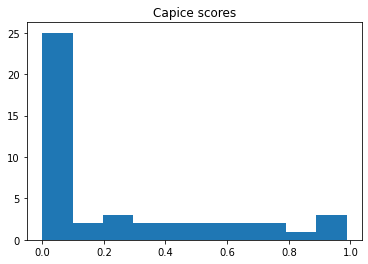

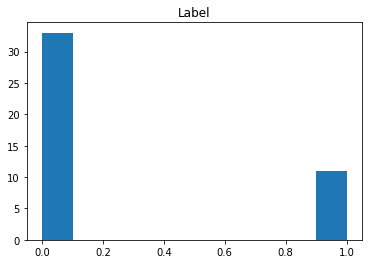

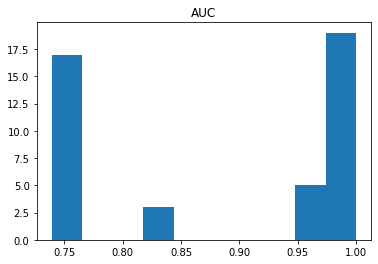

In [24]:
# Violinplots of the CAPICE scores vs labels in in_inflammatory

plt.hist(np.array(dataset[dataset['in_inflammatory'] == 1]['capice']))
plt.title('Capice scores')
plt.show()
plt.hist(np.array(dataset[dataset['in_inflammatory'] == 1]['label']))
plt.title('Label')
plt.show()
plt.hist(np.array(dataset[dataset['in_inflammatory'] == 1]['auc']))
plt.title('AUC')
plt.show()

# Investigate pathogenic label for MEFV

In [25]:
# Dropping to save space

dataset.drop(['in_inflammatory'], axis=1, inplace=True)

/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


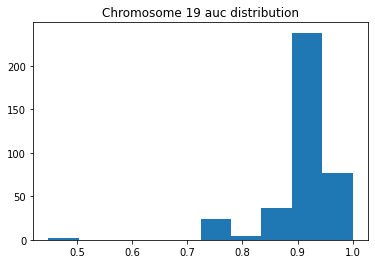

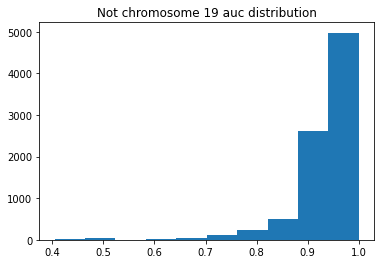

In [26]:
# Randomly selected chromosome 19 auc distribution vs not chromosome 19 auc distribution

plt.hist(np.array(dataset[dataset['#Chrom'] == "19"]['auc']))
plt.title('Chromosome 19 auc distribution')
plt.show()

plt.hist(np.array(dataset[dataset['#Chrom'] != "19"]['auc']))
plt.title('Not chromosome 19 auc distribution')
plt.show()


<ipython-input-29-aab394b495a3>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.hist(np.array(dataset[dataset['#Chrom'] == chromosome][dataset['auc'].notnull()]['auc']),


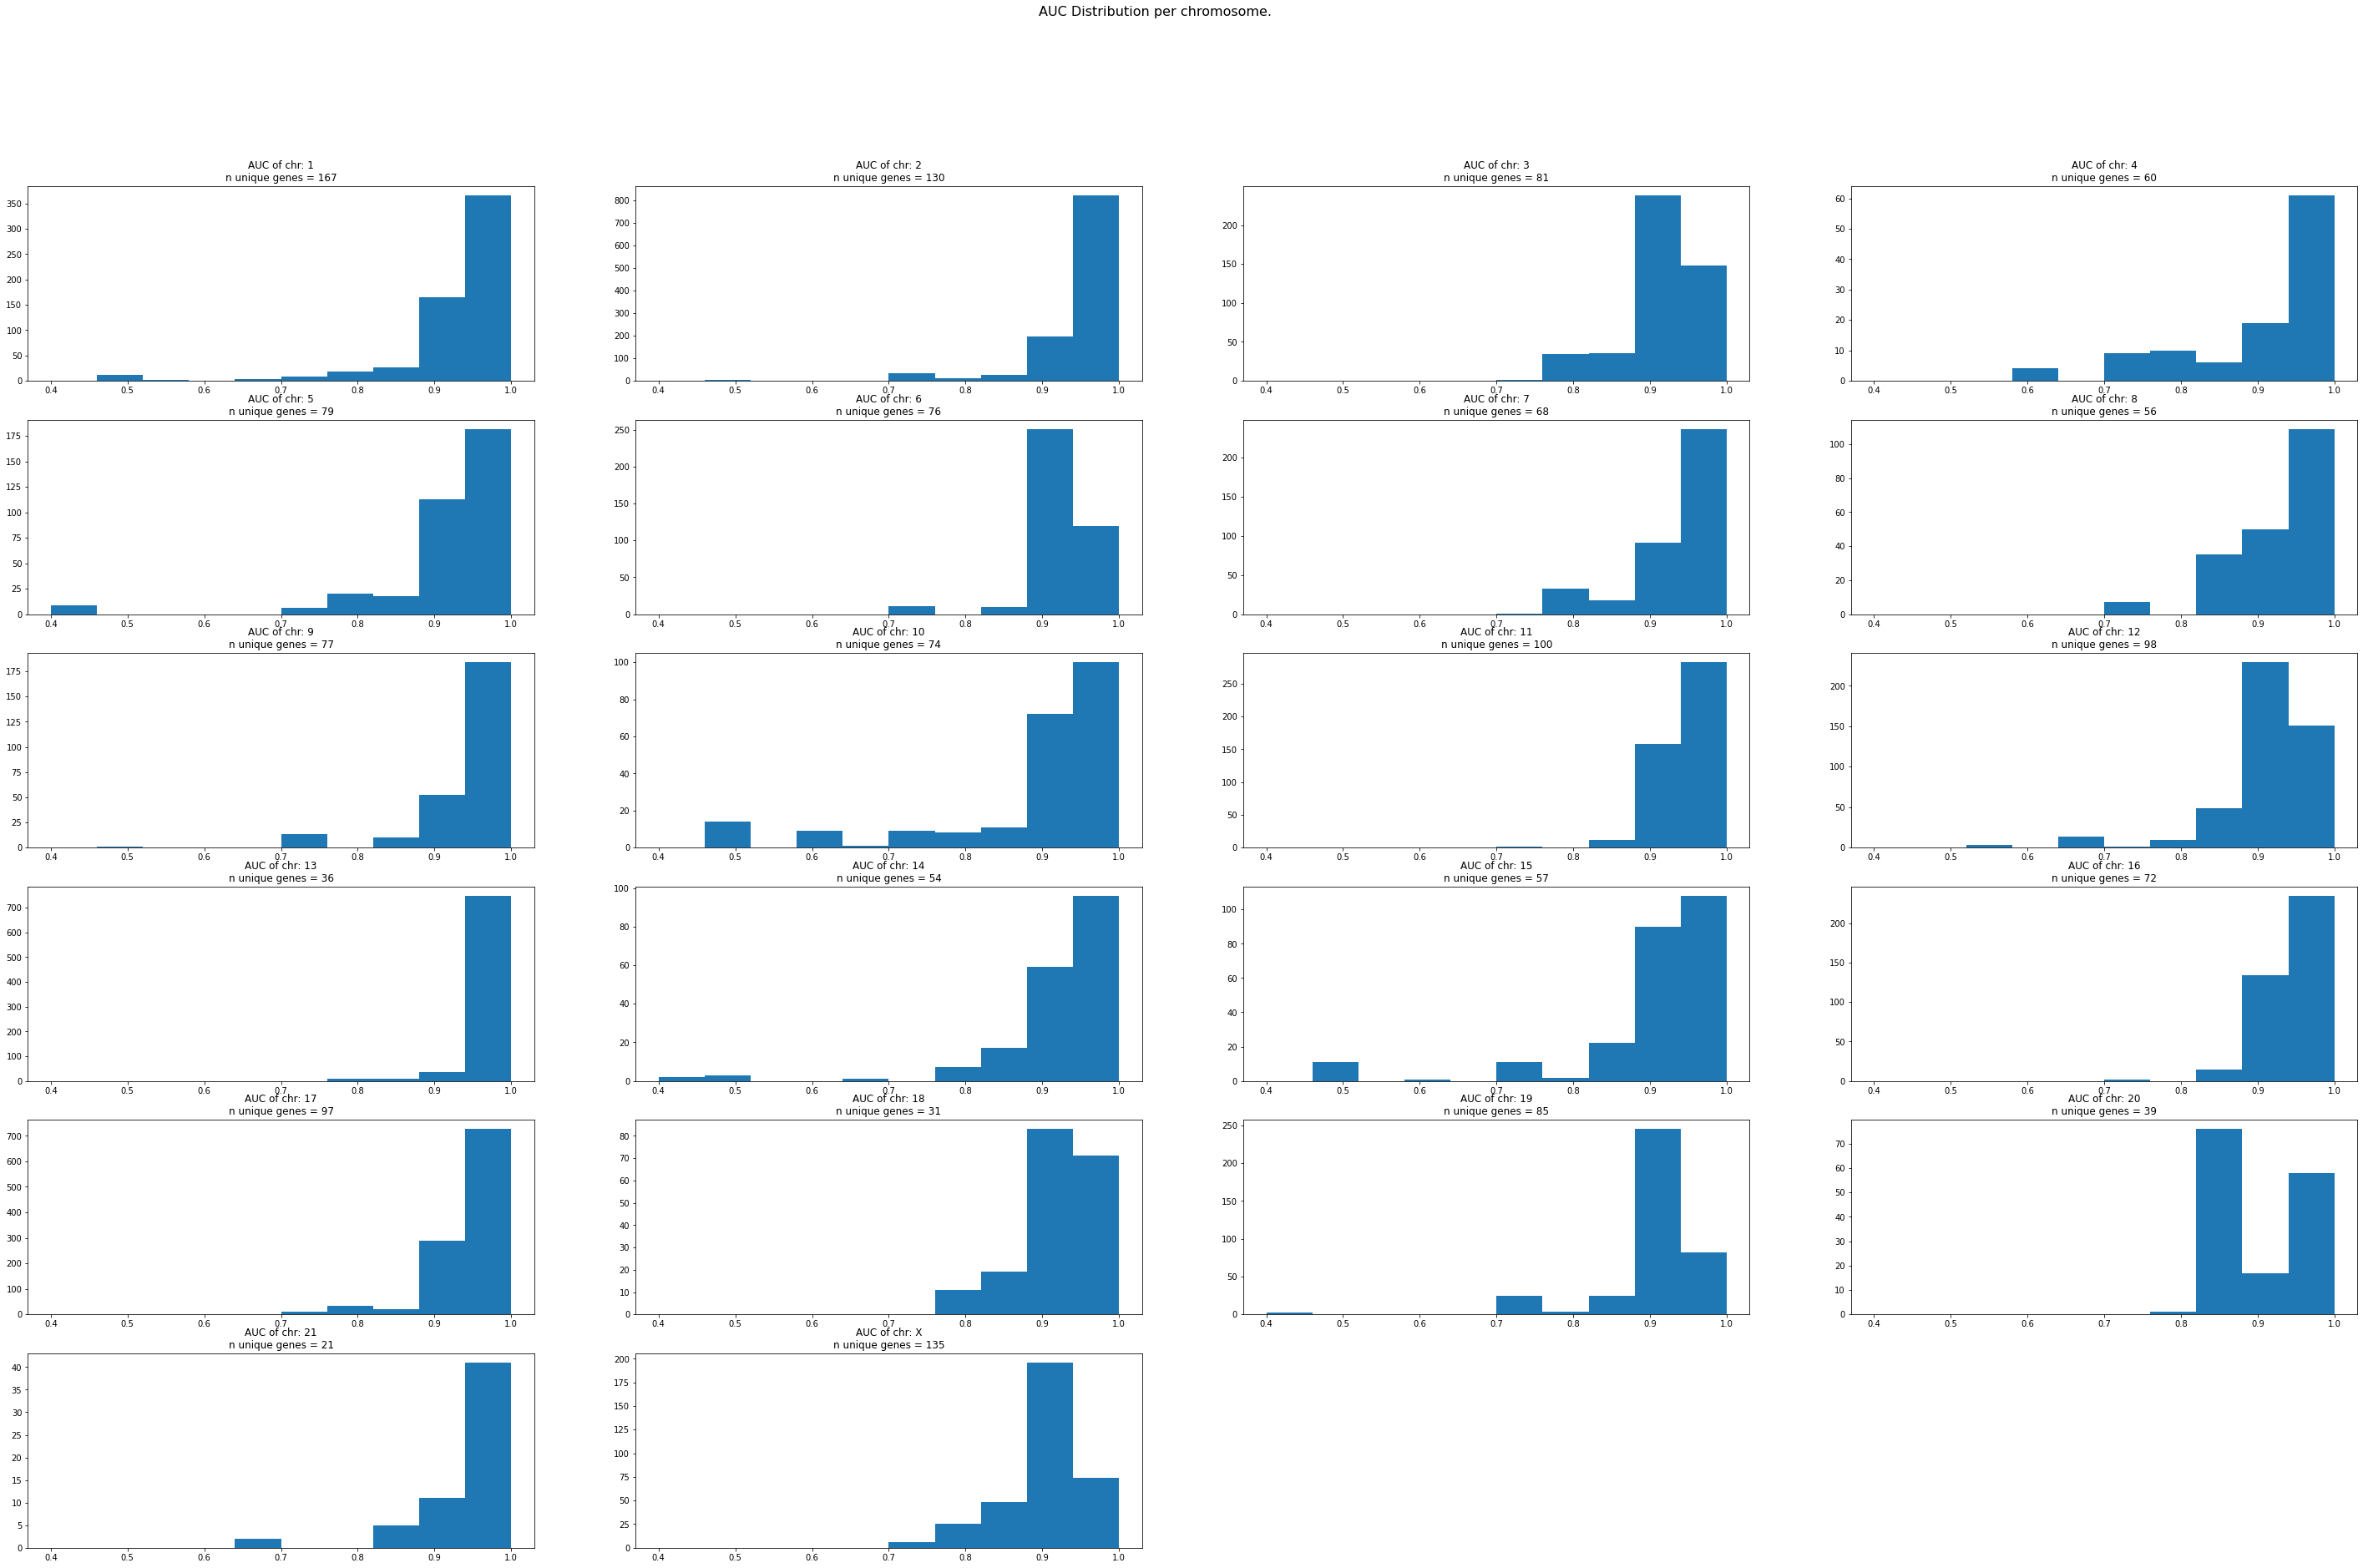

In [29]:
# Let's do that for all chromosomes

dataset.sort_values(by=['#Chrom'], inplace=True)

chromosomes = np.arange(1,22).astype('str').tolist() + ['X','Y','mt']

plt.figure(figsize=(50,30))
i = 1

min_axes = None

for chromosome in chromosomes:
    if chromosome not in list(dataset['#Chrom'].unique()):
        continue
    ax = plt.subplot(6, 4, i)
    ax.hist(np.array(dataset[dataset['#Chrom'] == chromosome][dataset['auc'].notnull()]['auc']),
           range=(0.4,1.0))
    ax.set_title(f'AUC of chr: {chromosome}\n'
                 f'n unique genes = {dataset[dataset["#Chrom"] == chromosome]["gene"].unique().size}')
    i+=1

plt.suptitle('AUC Distribution per chromosome.', fontsize=16)
image_name = f'{datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S_%f")} AUCDistPerChrom.png' 
    
# plt.savefig('/home/'+location+'/PycharmProjects/dsls_master_thesis/side_scripts/output_img/'+image_name)    
plt.show()

# Change to histogram

In [28]:
# Getting the genes that do not perform well for chomosome 14

dataset[dataset['#Chrom'] == '4'][dataset['auc'].notnull()].sort_values(by=['auc'])

<ipython-input-28-125f02c3f083>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset[dataset['#Chrom'] == '4'][dataset['auc'].notnull()].sort_values(by=['auc'])


,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic
4693,4,140258100,CAT,C,0.000036,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,32.0,NaN,0.871369,NaN,NAA15,0.607143,0
4692,4,140258052,G,T,0.000000,STOP_GAINED,0,NaN,NaN,NaN,NaN,36.0,0.279859,0.279109,NaN,NAA15,0.607143,0
4691,4,140283092,G,A,0.000009,CANONICAL_SPLICE,0,NaN,NaN,NaN,NaN,34.0,0.991858,0.923943,NaN,NAA15,0.607143,0
4694,4,140291436,GAAGAA,G,0.000000,FRAME_SHIFT,1,NaN,NaN,NaN,NaN,35.0,NaN,0.316003,NaN,NAA15,0.607143,0
3826,4,68441202,G,T,0.000009,STOP_GAINED,0,NaN,NaN,NaN,NaN,44.0,NaN,0.066932,NaN,STAP1,0.732014,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10358,4,146567164,ATGAC,A,0.000081,FRAME_SHIFT,1,NaN,NaN,NaN,NaN,35.0,NaN,0.977630,NaN,MMAA,1.000000,0
10359,4,146567161,C,T,0.000018,STOP_GAINED,1,NaN,NaN,NaN,NaN,39.0,NaN,0.974990,NaN,MMAA,1.000000,0
10460,4,104577415,C,T,0.000869,STOP_GAINED,1,NaN,NaN,NaN,NaN,45.0,NaN,0.907078,NaN,TACR3,1.000000,0
1119,4,39276448,T,G,0.000030,NON_SYNONYMOUS,0,0.490,0.884646,0.996,2.53,24.2,NaN,0.023756,0.530,WDR19,1.000000,0


# What have I done:
- Plotted the AUC vs number of (benign / pathogenic / combined) samples. Pathogenic seems interestinging enough to investigate further.
    - Maybe try an analysis of CADD and CAPICE ordered by the amount of pathogenic samples?
- Made home environment workable
    - Went from an Core I3-6200U @2.3 GHz and a NVIDIA GTX 940M to a AMD Ryzen 7 1800X @4 GHz and a NVIDIA GTX 1080Ti (Much much more processing power)
- Cleaned data
- Scraped gene list
    
# What must be done:
- Finish research proposal
- Get access to the umcg-gcc groups folder
- Calculate AUC for testing phase for CAPICE
- Calculate AUC for training and testing phase for CADD
- Investigate whenever the cutoff for CAPICE (0.02) and CADD (30) have the best AUC.
- Investigate the bad performing chromosomes on their characteristics (like how much is labeled benign / pathogenic)
- Split bad performing chromosomes into AUC for SNV's labeled LB/B and LP/P
- __For all genes, annotate them with all data available for them (like length, symtomps linkage, genenetwork, you name it), find correlations and causations for good / bad AUC.__ 
    - Start with the obvious, like the amount of training samples, then dive into literature for more precise markers / features
- Search for papers that define the penetrance of a gene, chanses of dominant / recessive

# TODO:
- Finish proposal, then investigate new gene features that might explain bad AUC (or good), then 
    
    
To add onto the idea of novel annotations, below are some of the ideas I find interesting:
- pLI (loss of intolerance)
- Popmax filtering AF (we might be already using it in benchmarking but I guess there is no harm in explicitly testing it?)
- [pext](https://www.biorxiv.org/content/10.1101/554444v1)
- [Enhancer features](https://www.sciencedirect.com/science/article/abs/pii/S0002929720300124)
- Features included in this [paper](https://www.nature.com/articles/s41467-019-13212-3)

Interesting papers:

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6369448/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5618255/ (supplement 5)




In [29]:
# Loading in the first generated train dataset.

plain_data = pd.read_csv(read_loc+"auc_results.csv", header=0, index_col=0)
plain_data.head()

,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs
1,BRCA1,0.949156,0.001451,0.941821,0.998549,0.969355,848,1378,1,2226
2,LDLR,0.905925,0.006061,0.941627,0.993939,0.967076,335,990,1,1325
3,MSH2,0.955128,0.000000,0.929293,1.000000,0.963351,390,460,1,850
4,BRCA2,0.946305,0.000569,0.931034,0.999431,0.964021,1217,1756,1,2973
5,USH2A,0.944790,0.013333,0.831461,0.986667,0.902439,309,150,1,459


In [30]:
temp_plain_data = plain_data[plain_data['N_benign'] > 5]
temp_plain_data = temp_plain_data[temp_plain_data['N_malign'] > 5]
temp_plain_data.sort_values(by=['AUC'])

,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs
792,ANOS1,0.642857,0.000000,0.750000,1.000000,0.857143,7,15,1,22
1168,ARID2,0.652174,0.000000,0.448276,1.000000,0.619048,23,13,1,36
459,EBF3,0.666667,0.000000,0.703704,1.000000,0.826087,12,19,1,31
1373,RPL5,0.669643,0.285714,0.625000,0.714286,0.666667,8,7,1,15
22,DDX3X,0.700000,0.000000,0.913043,1.000000,0.954545,10,63,1,73
...,...,...,...,...,...,...,...,...,...,...
393,HMBS,1.000000,0.000000,1.000000,1.000000,1.000000,21,14,1,35
1409,GUCY2D,1.000000,0.000000,1.000000,1.000000,1.000000,35,10,1,45
285,XPA,1.000000,0.000000,1.000000,1.000000,1.000000,7,6,1,13
1100,ALDOB,1.000000,0.000000,1.000000,1.000000,1.000000,16,16,1,32


In [31]:
plain_data.sort_values(by=['AUC']).head(10)

,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs
2679,AFF4,0.400000,1.0,0.0,0.0,0.0,20,1,1,21
2353,GFM2,0.404762,1.0,0.0,0.0,0.0,105,2,1,107
2816,RTN2,0.448276,1.0,0.0,0.0,0.0,29,1,1,30
2422,SPTLC2,0.458937,1.0,0.0,0.0,0.0,207,1,1,208
2449,CACNB2,0.469003,1.0,0.0,0.0,0.0,371,1,1,372
3120,DFNA5,0.472222,1.0,0.0,0.0,0.0,36,1,1,37
2605,GIGYF2,0.483137,1.0,0.0,0.0,0.0,593,1,1,594
2894,JAK2,0.485380,1.0,0.0,0.0,0.0,171,1,1,172
2619,LDB3,0.486355,1.0,0.0,0.0,0.0,513,1,1,514
2874,NRXN3,0.490248,1.0,0.0,0.0,0.0,564,1,1,565


In [32]:
# Load in train data
train_data = pd.read_csv(read_loc+"train.txt", sep='\t',header=0)
train_data.head()

,#Chrom,Pos,Ref,Alt,Consequence,max_AF,label
0,14,68196054,GCCCTG,G,FRAME_SHIFT,0.0,LP/P
1,20,10626717,TCA,T,STOP_GAINED,0.0,LP/P
2,20,10625898,CTG,C,FRAME_SHIFT,0.0,LP/P
3,20,10628741,AC,A,FRAME_SHIFT,0.0,LP/P
4,20,10625509,ACT,A,DOWNSTREAM,0.0,LP/P


In [33]:
genes = pd.read_csv(read_loc+'agilent_compressed.csv', header=0,index_col=0)
genes.head()

,chr,start,stop,gene
0,1,69041,70059,OR4F5
0,1,138480,139360,AL627309.1
0,1,367609,368648,OR4F3
0,1,367609,368648,OR4F16
0,1,367609,368648,OR4F29


In [34]:
def genes_in_dataset(dataset, genes):
    dataset['gene'] = np.NaN
    time_before_whileloop = time.time()
    total_rows = genes.shape[0]
    done_rows = 0
    time_forloop_started = time.time()
    for gene in genes.iterrows():
        time_in_whileloop = time.time()
        if time_in_whileloop - time_before_whileloop > 10:
            print(f"I'm still running, I've been running for: "
                    f"{round(divmod(time_in_whileloop - time_forloop_started, 60)[0])}"
                    f" minutes and "
                    f"{round(divmod(time_in_whileloop - time_forloop_started, 60)[1])}"
                    f" seconds.")
            print(f'Done {round(done_rows/total_rows*100, ndigits=2)} %.')
            time_before_whileloop = time.time()
        gene = gene[1]
        subset_chr = dataset[dataset['#Chrom'] == gene['chr']]
        subset_min = subset_chr[subset_chr['Pos'] >= gene['start']]
        full_subset = subset_min[subset_min['Pos'] <= gene['stop']]
        if full_subset.shape[0] > 0:
            dataset.loc[full_subset.index, 'gene'] = gene['gene']
        done_rows += 1
    return dataset

In [35]:
# train_data = genes_in_dataset(train_data, genes)
# train_data

In [36]:
# Which genes are not in train, but in test?

# genes_test = dataset['gene'].unique().tolist()
# genes_train = train_data['gene'].unique().tolist()
# for gene in genes_test:
#     if gene not in genes_train:
#         print(f'Gene {gene} was not in training!')

In [37]:
plain_data[plain_data['Gene'] == 'PHLDA2']

,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs
5704,PHLDA2,NaN,NaN,NaN,NaN,NaN,1,0,0,1


# Calculating optimal AUC per gene where possible
Initially in Shuang her paper, she mentioned a CAPICE cutoff of 0.02 for overall performance. I want to see if this can be adjusted to a per gene performance. 

In [38]:
# Load in train data
train_data = pd.read_csv(read_loc+"train.txt", sep='\t',header=0)
train_results = pd.read_csv(read_loc+'train_results.txt', sep='\t', header=0)
train_results.head()

,chr,pos,ref,alt,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction
0,17,41246652,ACATTC,GA,BRCA1,FRAME_SHIFT,26.6,0.999993,Pathogenic,Pathogenic
1,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,LDLR,FRAME_SHIFT,35.0,0.999991,Pathogenic,Pathogenic
2,19,11216251,GGACAAATCTGACGA,AACTGCGGTAAACTGCGGTAAACT,LDLR,FRAME_SHIFT,34.0,0.999990,Pathogenic,Pathogenic
3,19,11216262,ACG,CA,LDLR,FRAME_SHIFT,34.0,0.999989,Pathogenic,Pathogenic
4,2,47702328,GTTGA,TTTC,MSH2,FRAME_SHIFT,35.0,0.999989,Pathogenic,Pathogenic


In [39]:
merged_train = pd.merge(train_data, train_results, left_on=['#Chrom','Pos','Ref','Alt'],
                       right_on=['chr','pos','ref','alt'])
merged_train.columns

Index(['#Chrom', 'Pos', 'Ref', 'Alt', 'Consequence_x', 'max_AF', 'label',
       'chr', 'pos', 'ref', 'alt', 'GeneName', 'Consequence_y', 'PHRED',
       'probabilities', 'prediction', 'combined_prediction'],
      dtype='object')

In [40]:
merged_train = merged_train[['#Chrom', 'Pos', 'Ref', 'Alt', 'label',
       'GeneName', 'Consequence_y', 'probabilities']]
merged_train.columns = ['chr','pos','ref','alt','label','gene','consequence','capice']
# merged_train.to_csv(read_loc+"merged_train.csv",index=False)

In [41]:
# Load in the multiprocessed optimally mapped auc thresholds.

optimal_auc = pd.read_csv(read_loc+'optimal_auc_thresholds.csv', header=0)

# See what genes have improved.
improved_auc = optimal_auc[optimal_auc['default_auc'] != optimal_auc['optimal_auc']]


In [42]:
optimal_auc[optimal_auc['optimal_c'] == 0.02]

,gene,default_auc,optimal_c,optimal_auc,improved,n_tot,n_benign,n_malign
0,RDH12,0.928571,0.02,0.928571,0.0,8,7,1
1,EIF2AK3,1.000000,0.02,1.000000,0.0,29,24,5
2,EIF2AK4,0.950000,0.02,0.950000,0.0,12,10,2
4,PRKAG2,0.981818,0.02,0.981818,0.0,175,165,10
5,STRC,0.945195,0.02,0.945195,0.0,55,37,18
...,...,...,...,...,...,...,...,...
2299,GYS2,0.985294,0.02,0.985294,0.0,41,34,7
2301,ERBB3,0.961538,0.02,0.961538,0.0,15,13,2
2304,ZIC1,1.000000,0.02,1.000000,0.0,3,2,1
2305,OPN1LW,1.000000,0.02,1.000000,0.0,17,16,1


In [43]:
print(f"Default average performance: {improved_auc['default_auc'].mean()}, "
      f"optimal average performance: {improved_auc['optimal_auc'].mean()}")

Default average performance: 0.9137959608096636, optimal average performance: 0.9466309732063938


In [44]:
improved_auc.sort_values(by=['improved'], ascending=False)

,gene,default_auc,optimal_c,optimal_auc,improved,n_tot,n_benign,n_malign
2296,TMPRSS6,0.500000,0.024,1.000000,0.500000,15,14,1
198,RTN2,0.448276,0.024,0.948276,0.500000,30,29,1
2060,AFF4,0.400000,0.024,0.900000,0.500000,21,20,1
2282,SPTLC2,0.458937,0.024,0.956522,0.497585,208,207,1
1678,IRAK3,0.538462,0.046,0.923077,0.384615,15,13,2
...,...,...,...,...,...,...,...,...
303,ALMS1,0.972527,0.026,0.974288,0.001761,327,284,43
1454,TGFBI,0.991667,0.025,0.993056,0.001389,361,360,1
1202,EPHA2,0.995037,0.028,0.996278,0.001241,405,403,2
842,CELSR2,0.998873,0.030,1.000000,0.001127,888,887,1


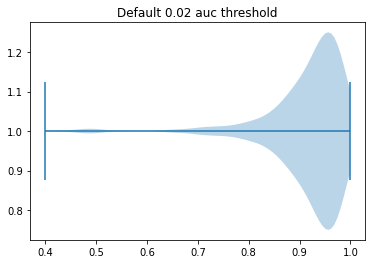

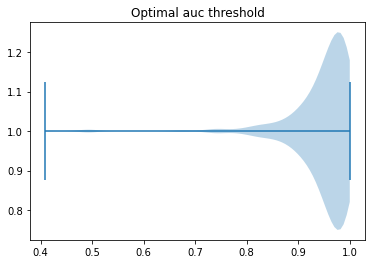

In [45]:
plt.violinplot(np.array(improved_auc['default_auc']),vert=False)
plt.title('Default 0.02 auc threshold')
plt.show()
plt.violinplot(np.array(improved_auc['optimal_auc']),vert=False)
plt.title('Optimal auc threshold')
plt.show()

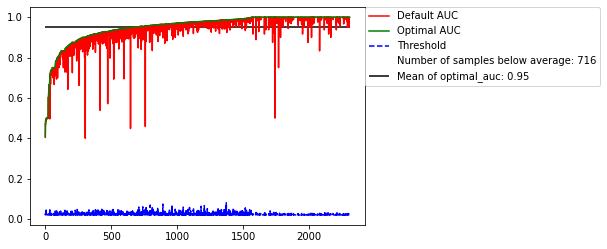

In [46]:
sorting = 'optimal_auc'

sorted_optimal = optimal_auc.sort_values(by=[sorting], ascending=True)

x_axis = np.arange(sorted_optimal.shape[0])
y_d_auc = np.array(sorted_optimal['default_auc'])
y_o_auc = np.array(sorted_optimal['optimal_auc'])
y_thres = np.array(sorted_optimal['optimal_c'])

sorting_mean = sorted_optimal[sorting].mean()
n_below = sorted_optimal[sorted_optimal[sorting] < sorting_mean].shape[0]

plt.plot(x_axis, y_d_auc, 'r-', label='Default AUC')
plt.plot(x_axis, y_o_auc, 'g-', label='Optimal AUC')
plt.hlines(sorting_mean, xmin=0,xmax=x_axis.size,
          label='Mean of '+sorting+": "+str(round(sorting_mean, ndigits=2)))
plt.plot(x_axis, y_thres, 'b--', label='Threshold')
plt.plot([],[],' ',label='Number of samples below average: '+str(n_below))
plt.legend(loc='lower right', bbox_to_anchor=(1.718,0.615), fancybox=True, frameon=True)
plt.show()



- Fase 1: can we let machine learning explain the reason behind both low and high AUC values based on various properties of genes such as organ manifestions, loss-of-function intolerance, disease inheritance mode, disease heterogeneity/penetrance (patient 1 has variant, is ill, patient 2 has also variant, but is not ill), regulation by QTL, methylation, quality of training data, etc (?)

- Fase 2: using the knowledge of resistant/compliant genes, and, machine-learned features that explain this difference in performance, can we rebuild CAPICE scores with new information and correctly classify variants located in these ‘resistant’ genes?

- Fase 3 (optional): Identify new and informative models that perform better than the gradient boosted tree model.


In [47]:
optimal_auc[optimal_auc['optimal_auc'] < 0.6].sort_values(by='optimal_auc')

,gene,default_auc,optimal_c,optimal_auc,improved,n_tot,n_benign,n_malign
1823,GFM2,0.404762,0.026,0.409524,0.004762,107,105,2
686,DFNA5,0.472222,0.020,0.472222,0.000000,37,36,1
2138,CACNB2,0.469003,0.027,0.475741,0.006739,372,371,1
1086,NRXN3,0.490248,0.028,0.492908,0.002660,565,564,1
2261,JAK2,0.485380,0.031,0.494152,0.008772,172,171,1
947,GJB3,0.494318,0.020,0.494318,0.000000,90,88,2
1916,GIGYF2,0.483137,0.041,0.494941,0.011804,594,593,1
1687,LDB3,0.486355,0.044,0.496101,0.009747,514,513,1
1991,NDUFA1,0.500000,0.020,0.500000,0.000000,12,11,1
1963,SLC25A3,0.500000,0.020,0.500000,0.000000,8,7,1


In [48]:
# DFNA5, when looked up, seems to have pathogenic variants in an exome, where capice scores are very low.
# But further in, more pathogenic variants are found with a very high capice score but intronic.

# https://molgenis26.gcc.rug.nl/downloads/capice/plots/Agilent_Exoom_v3_human_g1k_v37/DFNA5.png

- [TCF20](https://molgenis26.gcc.rug.nl/downloads/capice/plots/Agilent_Exoom_v3_human_g1k_v37/TCF20.png) seems to benefit if intronic/exonic is taken into account.
- [DFNA5](https://molgenis26.gcc.rug.nl/downloads/capice/plots/Agilent_Exoom_v3_human_g1k_v37/DFNA5.png) seems to have a very strange pattern of pathogenic variants in a large intronic region. CAPICE is also high for those variants, but variants that are exonic, have a low CAPICE score interestingly.
- MRPS34 is not found
- GJB3 is not found
- [LIPE](https://molgenis26.gcc.rug.nl/downloads/capice/plots/Agilent_Exoom_v3_human_g1k_v37/LIPE.png) seems fine honestly. No clue why that AUC is so low. My data shows less datapoints than the plots on molgenis. Maybe map genes personally?
- [GRID2](https://molgenis26.gcc.rug.nl/downloads/capice/plots/Agilent_Exoom_v3_human_g1k_v37/GRID2.png) just what the hell is this? Unmapped gene? Also when I look at that picture from molgenis, it seems that there are a LOT more training samples compared to what my data shows... Do I have the correct dataset?
- IL1RN is not found
- KBTBD13 is not found
- [NRXN3](https://molgenis26.gcc.rug.nl/downloads/capice/plots/Agilent_Exoom_v3_human_g1k_v37/NRXN3.png) is just like GRID2 all over the place.
- [RBP3](https://molgenis26.gcc.rug.nl/downloads/capice/plots/Agilent_Exoom_v3_human_g1k_v37/RBP3.png) seems fine, but again, less pathogenic samples as the plot of molgenis provides.
- [SLC6A9](https://molgenis26.gcc.rug.nl/downloads/capice/plots/Agilent_Exoom_v3_human_g1k_v37/SLC6A9.png) is another example to why I don't think the AUC should be bad.
- HPS6 is not found
- [LDB3](https://molgenis26.gcc.rug.nl/downloads/capice/plots/Agilent_Exoom_v3_human_g1k_v37/LDB3.png) is an example to why I think that there are extra features required, a lot of the benign samples are marked as pathogenic. Lots of false positives.
    - Maybe add FPR and Recall to stats of my mapper function?
- NLRP1 is not found
- CEACAM16 is not found
- [GFM2](https://molgenis26.gcc.rug.nl/downloads/capice/plots/Agilent_Exoom_v3_human_g1k_v37/GFM2.png) lots of false positives, some false negatives.
    - The worst performer, my map reduce algorithm improved it a bit by increasing the threshold, but it is far from ideal.
- RAB11B is not found
- GIGYF2 is not found
- SLC25A3 is not found
- NDUFA1 is not found
- [CACNB2](https://molgenis26.gcc.rug.nl/downloads/capice/plots/Agilent_Exoom_v3_human_g1k_v37/CACNB2.png) seems fine, but it does have some false positives.
- [JAK2](https://molgenis26.gcc.rug.nl/downloads/capice/plots/Agilent_Exoom_v3_human_g1k_v37/JAK2.png) shouldn't have this low of an AUC, on plot it seems fine.

# Bottom line: personally map genes to the SNV files

- Is there a pattern in genes that do not perform well in CAPICE?
Same could be questioned for genes that do perform well (pessimist vs optimist point of view)

- What features are key drivers within the CAPICE model?

- Is a gradient boosted tree model really the best approach? (yes, I’m very sceptical about the gradient boosting, even if it performs well)


# Notes meeting 24-03-2020
- Get all genes that perform bad from the histograms earlier in this notebook
- Add FPR, recall, sensitivity and specificity to mapper function
- Add vkgl and test data to optimum AUC mapper
- *see school bookmark for gene panels* calculate auc and compare auc's
    - Immunodeficiency (big chunk)
    - Developmental delay
    - 5GPM everything except late onset, but is very large
    - More popular panels will have more information, possibly easier to interpret.
 - Phase 1:
     - Make a list of biases and other easy to test statistics per gene / chromosome
     - Grab genes that are difficult to predict and label them.
     - Apply (NaN)GMLVQ on (to predict) to show correlations / causations.


[google docs](https://docs.google.com/document/d/1D5SiNbeDEfY2hTWquS88MGUrLv6IgZzfCzflppRGb5k/edit) of what is interesting


In [49]:
test_dataset = pd.read_csv(read_loc+'test_results.csv', header=0, index_col=0)
vkgl_train = pd.read_csv(read_loc+'VKGL_14nov2019.txt', sep='\t', header=0)
vkgl_res = pd.read_csv(read_loc+'VKGL_14nov2019_capice.txt', sep='\t', header=0)

In [50]:
print(test_dataset.head())
print("____________________")
print(vkgl_train.head())
print("____________________")
print(vkgl_res.head())

  #Chrom       Pos Ref Alt    max_AF Consequence label  revel  clinpred  \
0     21  33974174   C   G  0.000058   STOP_LOST  LB/B    NaN       NaN   
1      X  99661625   G   C  0.000037  SYNONYMOUS  LB/B    NaN       NaN   
2     17  29509638   C   T  0.000000  SYNONYMOUS  LB/B    NaN       NaN   
3     21  35742999   C   T  0.000133  SYNONYMOUS  LB/B    NaN       NaN   
4      1   2160973   G   A  0.000000  SYNONYMOUS  LB/B    NaN       NaN   

    sift  provean   PHRED  fathmm_score    capice  ponp2      gene  
0    NaN      NaN  15.050           NaN  0.003275    NaN  C21orf59  
1  0.000     -0.0   0.806           NaN  0.000075    NaN    PCDH19  
2  0.647     -0.0  10.760           NaN  0.001511    NaN       NF1  
3  0.000     -0.0  18.640           NaN  0.000621    NaN     KCNE2  
4  0.000     -0.0  16.340      0.008252  0.000012    NaN       SKI  
____________________
                  Variant Chromosome  Start position Reference allele  \
0   14:105167860 INF2 T>G         14     

In [51]:
vkgl_train = vkgl_train[['Chromosome','Start position',
                         'Reference allele','Alternative allele',
                        'Gene', 'Classification']]
vkgl_train.columns = ['chr', 'pos', 'ref', 'alt', 'gene', 'label']
vkgl_train['source'] = 'vkgl'

In [52]:
vkgl_res.columns = ['chr', 'pos', 'ref', 'alt', 'consequence', 'capice']

In [53]:
vkgl_merged = pd.merge(vkgl_train, vkgl_res, on=['chr', 'pos', 'ref', 'alt'], suffixes=('','_res'))
vkgl_merged.loc[vkgl_merged[vkgl_merged['label'] == 'VUS'].index, 'label'] = np.NaN

In [54]:
nan_label_vgkl = vkgl_merged[vkgl_merged['label'].isnull()]

In [55]:
print('Ordered genes with the amount of VUS variants they have in the VKGL dataset.')
nan_label_vgkl.pivot_table(index=['gene'], aggfunc='size').sort_values(ascending=False).head(25)

Ordered genes with the amount of VUS variants they have in the VKGL dataset.


gene
TTN       1679
MYH6       187
MYH7       186
NF1        171
USH2A      169
MYBPC3     157
MEFV       152
RYR2       151
SCN5A      145
CDH23      135
FLNC       131
DSP        130
BRCA2      130
SYNE1      126
APOB       120
ADGRV1     116
RYR1       115
PLEC       114
BRCA1      101
LAMA4       95
ABCA4       94
NOTCH1      94
FBN1        93
FLNA        88
MYO7A       88
dtype: int64

In [56]:
vkgl_merged.drop(vkgl_merged[vkgl_merged['label'].isnull()].index, axis=0, inplace=True)
vkgl_merged

,chr,pos,ref,alt,gene,label,source,consequence,capice
0,14,105167860,T,G,INF2,LP/P,vkgl,NON_SYNONYMOUS,0.097502
1,4,995586,C,T,IDUA,LB/B,vkgl,NON_SYNONYMOUS,0.008946
2,16,51172677,G,A,SALL1,LB/B,vkgl,SYNONYMOUS,0.000967
4,19,55449589,G,A,NLRP7,LB/B,vkgl,NON_SYNONYMOUS,0.000096
5,2,98354472,G,A,ZAP70,LB/B,vkgl,SYNONYMOUS,0.000011
...,...,...,...,...,...,...,...,...,...
149399,7,103212617,A,G,RELN,LB/B,vkgl,INTRONIC,0.000031
149402,2,44101597,C,A,ABCG8,LP/P,vkgl,NON_SYNONYMOUS,0.009213
149403,2,220285023,A,G,DES,LB/B,vkgl,DOWNSTREAM,0.003574
149404,15,57953648,A,T,GCOM1,LB/B,vkgl,NON_SYNONYMOUS,0.043776


In [57]:
merged_train['source'] = 'train'
vkgl_merged = vkgl_merged.reindex(columns=merged_train.columns)
vkgl_merged

,chr,pos,ref,alt,label,gene,consequence,capice,source
0,14,105167860,T,G,LP/P,INF2,NON_SYNONYMOUS,0.097502,vkgl
1,4,995586,C,T,LB/B,IDUA,NON_SYNONYMOUS,0.008946,vkgl
2,16,51172677,G,A,LB/B,SALL1,SYNONYMOUS,0.000967,vkgl
4,19,55449589,G,A,LB/B,NLRP7,NON_SYNONYMOUS,0.000096,vkgl
5,2,98354472,G,A,LB/B,ZAP70,SYNONYMOUS,0.000011,vkgl
...,...,...,...,...,...,...,...,...,...
149399,7,103212617,A,G,LB/B,RELN,INTRONIC,0.000031,vkgl
149402,2,44101597,C,A,LP/P,ABCG8,NON_SYNONYMOUS,0.009213,vkgl
149403,2,220285023,A,G,LB/B,DES,DOWNSTREAM,0.003574,vkgl
149404,15,57953648,A,T,LB/B,GCOM1,NON_SYNONYMOUS,0.043776,vkgl


In [58]:
vkgl_train_merge = merged_train.append(vkgl_merged)

In [59]:
vkgl_train_merge.drop_duplicates(keep='first', inplace=True)

In [60]:
del(vkgl_res, vkgl_train)
vkgl_train_merge

,chr,pos,ref,alt,label,gene,consequence,capice,source
0,14,68196054,GCCCTG,G,LP/P,RDH12,FRAME_SHIFT,0.988552,train
1,20,10626717,TCA,T,LP/P,JAG1,STOP_GAINED,0.990329,train
2,20,10625898,CTG,C,LP/P,JAG1,FRAME_SHIFT,0.991696,train
3,20,10628741,AC,A,LP/P,JAG1,FRAME_SHIFT,0.983607,train
4,20,10625509,ACT,A,LP/P,JAG1,DOWNSTREAM,0.987999,train
...,...,...,...,...,...,...,...,...,...
149399,7,103212617,A,G,LB/B,RELN,INTRONIC,0.000031,vkgl
149402,2,44101597,C,A,LP/P,ABCG8,NON_SYNONYMOUS,0.009213,vkgl
149403,2,220285023,A,G,LB/B,DES,DOWNSTREAM,0.003574,vkgl
149404,15,57953648,A,T,LB/B,GCOM1,NON_SYNONYMOUS,0.043776,vkgl


In [61]:
test_dataset = test_dataset[['#Chrom', 'Pos', 'Ref', 'Alt', 'Consequence', 'label', 'capice','gene']]
test_dataset['source'] = 'test'
test_dataset.columns = ['chr', 'pos', 'ref', 'alt', 'consequence', 'label', 'capice', 'gene', 'source']

In [62]:
test_dataset = test_dataset.reindex(columns=vkgl_train_merge.columns)
test_dataset

,chr,pos,ref,alt,label,gene,consequence,capice,source
0,21,33974174,C,G,LB/B,C21orf59,STOP_LOST,0.003275,test
1,X,99661625,G,C,LB/B,PCDH19,SYNONYMOUS,0.000075,test
2,17,29509638,C,T,LB/B,NF1,SYNONYMOUS,0.001511,test
3,21,35742999,C,T,LB/B,KCNE2,SYNONYMOUS,0.000621,test
4,1,2160973,G,A,LB/B,SKI,SYNONYMOUS,0.000012,test
...,...,...,...,...,...,...,...,...,...
10837,17,29556342,G,A,LP/P,NF1,SYNONYMOUS,0.000139,test
10838,11,5248177,A,T,LP/P,HBB,SYNONYMOUS,0.069934,test
10839,15,48787324,T,C,LP/P,FBN1,SYNONYMOUS,0.909190,test
10840,19,17947957,G,A,LP/P,JAK3,SYNONYMOUS,0.001238,test


In [63]:
full_ds = vkgl_train_merge.append(test_dataset)
full_ds['label'].unique()

array(['LP/P', 'LB/B'], dtype=object)

In [64]:
# full_ds.to_csv(read_loc+'full_dataset.csv', index=False)

In [69]:
full_mapped_ds = pd.read_csv(read_loc+'optimal_f1_full_ds.csv', header=0)
full_mapped_ds.sort_values(by='optimal_f1', ascending=False).head(10)

,gene,default_auc,default_f1,default_recall,default_fpr,default_spec,optimal_c,optimal_auc,optimal_f1,optimal_recall,optimal_fpr,optimal_spec,n_tot,n_benign,n_malign
915,ARMC9,1.000000,1.0,1.0,0.0,1.0,0.020,1.0,1.0,1.0,0.0,1.0,9,8,1
515,WNT1,1.000000,1.0,1.0,0.0,1.0,0.020,1.0,1.0,1.0,0.0,1.0,6,1,5
2252,DPM3,1.000000,1.0,1.0,0.0,1.0,0.020,1.0,1.0,1.0,0.0,1.0,5,3,2
871,BHLHA9,1.000000,1.0,1.0,0.0,1.0,0.020,1.0,1.0,1.0,0.0,1.0,6,5,1
999,DRC1,1.000000,1.0,1.0,0.0,1.0,0.020,1.0,1.0,1.0,0.0,1.0,49,46,3
2245,B9D2,1.000000,1.0,1.0,0.0,1.0,0.020,1.0,1.0,1.0,0.0,1.0,14,10,4
2244,B9D1,1.000000,1.0,1.0,0.0,1.0,0.020,1.0,1.0,1.0,0.0,1.0,18,16,2
512,DCLRE1C,0.911765,0.8,1.0,0.0,1.0,0.021,1.0,1.0,1.0,0.0,1.0,23,17,6
2242,RAB3GAP1,1.000000,1.0,1.0,0.0,1.0,0.020,1.0,1.0,1.0,0.0,1.0,72,55,17
2240,KIAA0753,1.000000,1.0,1.0,0.0,1.0,0.020,1.0,1.0,1.0,0.0,1.0,8,4,4


In [74]:
full_mapped_ds_v2 = pd.read_csv(read_loc+'optimal_f1_full_ds_v2.csv', header=0)


In [75]:
full_mapped_ds_v2.sort_values(by='optimal_f1', ascending=False).head(10)

,gene,default_auc,default_f1,default_recall,default_fpr,default_spec,optimal_c,optimal_auc,optimal_f1,optimal_recall,optimal_fpr,optimal_spec,n_tot,n_benign,n_malign
1506,LCA5,0.971429,0.75,1.000000,0.000000,1.000000,0.022,1.0,1.0,1.000000,0.000000,1.000000,38,35,3
1067,KISS1R,0.833333,0.80,0.666667,0.333333,0.666667,0.016,1.0,1.0,0.666667,0.333333,0.666667,12,9,3
2688,CTNNA2,1.000000,1.00,1.000000,0.000000,1.000000,0.020,1.0,1.0,1.000000,0.000000,1.000000,5,4,1
2202,ANTXR1,1.000000,1.00,1.000000,0.000000,1.000000,0.020,1.0,1.0,1.000000,0.000000,1.000000,23,20,3
1095,GRHPR,1.000000,1.00,1.000000,0.000000,1.000000,0.020,1.0,1.0,1.000000,0.000000,1.000000,29,8,21
2687,XPO1,1.000000,1.00,1.000000,0.000000,1.000000,0.020,1.0,1.0,1.000000,0.000000,1.000000,4,2,2
1826,TRAF3IP1,1.000000,1.00,1.000000,0.000000,1.000000,0.020,1.0,1.0,1.000000,0.000000,1.000000,12,10,2
1828,SUCLG1,1.000000,1.00,1.000000,0.000000,1.000000,0.020,1.0,1.0,1.000000,0.000000,1.000000,29,23,6
1086,PUS3,1.000000,1.00,1.000000,0.000000,1.000000,0.020,1.0,1.0,1.000000,0.000000,1.000000,5,4,1
1831,PYCR1,1.000000,1.00,1.000000,0.000000,1.000000,0.020,1.0,1.0,1.000000,0.000000,1.000000,30,14,16


In [80]:
filter_benign_fds = full_mapped_ds_v2['n_benign'] > 5
filter_malign_fds = full_mapped_ds_v2['n_malign'] > 5
plotted_map = full_mapped_ds_v2.where(filter_benign_fds & filter_malign_fds).dropna().sort_values(by='optimal_f1', ascending=False)

In [81]:
plotted_map[plotted_map['optimal_f1'] < 0.5]

,gene,default_auc,default_f1,default_recall,default_fpr,default_spec,optimal_c,optimal_auc,optimal_f1,optimal_recall,optimal_fpr,optimal_spec,n_tot,n_benign,n_malign
2316,SOS2,0.704545,0.333333,0.500000,0.500000,0.500000,0.016,0.866162,0.476190,0.500000,0.500000,0.500000,105.0,99.0,6.0
1686,CACNA1S,0.856339,0.418605,0.818182,0.181818,0.818182,0.025,0.867807,0.473684,0.818182,0.181818,0.818182,229.0,218.0,11.0
1297,PDGFRB,0.970126,0.387097,1.000000,0.000000,1.000000,0.024,0.977987,0.461538,1.000000,0.000000,1.000000,324.0,318.0,6.0
815,STS,0.763021,0.421053,0.666667,0.333333,0.666667,0.022,0.770833,0.444444,0.666667,0.333333,0.666667,70.0,64.0,6.0
1182,MTOR,0.851673,0.363636,0.800000,0.200000,0.800000,0.028,0.866543,0.444444,0.800000,0.200000,0.800000,279.0,269.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,MYH11,0.871699,0.188679,0.833333,0.166667,0.833333,0.023,0.874911,0.200000,0.833333,0.166667,0.833333,473.0,467.0,6.0
2455,GARS,0.561587,0.120000,0.230769,0.769231,0.230769,0.016,0.630599,0.175439,0.230769,0.769231,0.230769,329.0,316.0,13.0
2330,SPTLC2,0.455157,0.000000,0.000000,1.000000,0.000000,0.011,0.750374,0.170213,0.000000,1.000000,0.000000,229.0,223.0,6.0
2399,MUT,0.578992,0.075949,0.428571,0.571429,0.428571,0.010,0.724650,0.102564,0.428571,0.571429,0.428571,262.0,255.0,7.0


# EOF. For further analysis, see 'potential_gene_features.ipynb'